In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import config
import os.path
from os import path

from create_db import create_connection, create_table, clean_column_names
from populate_db import extract_data, insert_records
import query_db as qd

import importlib

In [2]:
importlib.reload(qd)

<module 'query_db' from '/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/query_db.py'>

In [3]:
import datetime

In [4]:
import re

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [20]:
#coded_offenses = pd.read_excel('https://github.com/christi-liongson/covid_decarceration/blob/construct_public_safety_data/data/Coding%20Offenses%20-%20For%20GitHub.xlsx',sheet_name="Coding - FINAL")
coded_offenses = pd.read_excel('../data/Coding Offenses - For GitHub.xlsx',sheet_name="Coding - FINAL")

In [22]:
coded_offenses.head()

,Primary offense code,Description (if needed),Decided Category,Needed a check?,More lenient,More harsh
0,DRIV LICENSE REVOKED,0,1,NO,1,1
1,LARCENY,0,2,YES,1,3
2,DWI DRIVING WHILE IMPAIRED,0,2,NO,2,2
3,FELONY B&E,"Felony Breaking and Entering, as opposed to Mi...",3,YES,2,4
4,WORTHLESS CHECK,0,1,NO,1,1


In [129]:
start = datetime.datetime.now()

query_inmt_profile = '''
                    SELECT *                           
                    FROM OFNT3DE1
                    LIMIT 100;
                    '''
conn = create_connection(config.database_name)
inmt_profile = qd.query_db_notebook(conn,query_inmt_profile)
conn.close

stop = datetime.datetime.now()
print("Time Elapsed:", stop - start) 


Time Elapsed: 0:00:00.059670


In [131]:
#inmt_profile

In [133]:
start = datetime.datetime.now()
query_court_commitment = '''
                        SELECT A.OFFENDER_NC_DOC_ID_NUMBER as ID, 
                            A.COMMITMENT_PREFIX, 
                            A.EARLIEST_SENTENCE_EFFECTIVE_DT, 
                            A.MOST_SERIOUS_OFFENSE_CODE                              
                        FROM OFNT3BB1 A
                        WHERE NEW_PERIOD_OF_INCARCERATION_FL = "Y";
                        '''

conn = create_connection(config.database_name)
court_small = qd.query_db_notebook(conn,query_court_commitment)


query_sentence_comp = '''
                            SELECT INMATE_DOC_NUMBER as ID, 
                                INMATE_COMMITMENT_PREFIX as COMMITMENT_PREFIX, 
                                INMATE_COMPUTATION_STATUS_FLAG, 
                                max(ACTUAL_SENTENCE_END_DATE) as END_DATE,
                                max(PROJECTED_RELEASE_DATE_PRD) as PROJ_END_DATE
                            FROM INMT4BB1
                            GROUP BY INMATE_DOC_NUMBER, INMATE_COMMITMENT_PREFIX;
                        '''

sentence_compute_small = qd.query_db_notebook(conn,query_sentence_comp)


query_inmt_profile = '''
                    SELECT 
                        INMATE_DOC_NUMBER as ID,
                        INMATE_RECORD_STATUS_CODE,
                        INMATE_ADMIN_STATUS_CODE,
                        DATE_OF_LAST_INMATE_MOVEMENT,
                        TYPE_OF_LAST_INMATE_MOVEMENT,
                        CURRENT_COMMITMENT_PREFIX,
                        INMATE_GENDER_CODE as GENDER,
                        INMATE_RACE_CODE as RACE,
                        INMATE_BIRTH_DATE as BIRTH_DATE,
                        INMATE_ETHNIC_AFFILIATION as ETHNICITY,
                        INMATE_CONTROL_STATUS_CODE as CONTROL_STATUS,
                        INMATE_SPECIAL_CHARACTERISTICS as SPECIAL_CHARS,
                        TOTAL_DISCIPLINE_INFRACTIONS,
                        LATEST_DISCIPLINE_INFRACTION,
                        LAST_DISCIPLINE_INFRACTION_DT
                    FROM INMT4AA1;
                    '''

query_inmt_profile = '''
                    SELECT 
                        INMATE_DOC_NUMBER as ID,
                        INMATE_RECORD_STATUS_CODE,
                        INMATE_ADMIN_STATUS_CODE,
                        DATE_OF_LAST_INMATE_MOVEMENT,
                        TYPE_OF_LAST_INMATE_MOVEMENT,
                        CURRENT_COMMITMENT_PREFIX,
                        INMATE_CONTROL_STATUS_CODE as CONTROL_STATUS
                    FROM INMT4AA1;
                    '''

inmt_profile = qd.query_db_notebook(conn,query_inmt_profile)

query_offender_profile = '''
                        SELECT 
                        OFFENDER_NC_DOC_ID_NUMBER as ID,
                        OFFENDER_GENDER_CODE as GENDER,
                        OFFENDER_RACE_CODE as RACE,
                        OFFENDER_BIRTH_DATE as BIRTH_DATE,
                        STATE_WHERE_OFFENDER_BORN as STATE_BORN,
                        OFFENDER_ETHNIC_CODE as ETHNICITY,
                        OFFENDER_CITIZENSHIP_CODE as CITIZENSHIP                        
                    FROM OFNT3AA1;
                            
                        '''

offender_profile = qd.query_db_notebook(conn,query_offender_profile)

query_disc_infraction = '''
                    SELECT INMATE_DOC_NUMBER as ID,
                            COUNT(*) as DISCIPLINARY_INFRACTION_COUNT                            
                    FROM INMT9CF1
                    GROUP BY INMATE_DOC_NUMBER;
                    '''


disc_infraction = qd.query_db_notebook(conn,query_disc_infraction)

conn.close

data = court_small.merge(sentence_compute_small, on=['ID','COMMITMENT_PREFIX'], how='outer')
data = data.merge(inmt_profile, on=['ID'], how = 'left')
data = data.merge(offender_profile, on=['ID'], how = 'left')
data = data.merge(disc_infraction, on=['ID'], how='left')


stop = datetime.datetime.now()
print("Time Elapsed:", stop - start) 


Time Elapsed: 0:02:00.577193


In [6]:
data.to_csv('datasetA_court_sentcomp.csv', index=False)

In [67]:
data.shape

(903181, 5)

In [95]:
data.groupby('INMATE_COMPUTATION_STATUS_FLAG').count()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,END_DATE
INMATE_COMPUTATION_STATUS_FLAG,,,,,
ACTIVE,27039,27039,27009,27009,27039
EAR.TERM,2970,2970,2897,2896,2970
EXPIRED,853716,853716,853022,530070,853716
FUTURE,6184,6184,6164,6164,6184
PAROLED,198,198,197,197,198
POST REL,11797,11797,11777,11777,11797
UNKNOWN,15,15,15,15,15


In [83]:
# Missing most serious offense code  - 324,308 - about a third of the data :(
data['MOST_SERIOUS_OFFENSE_CODE'].isnull().sum()

324308

In [96]:
# data in court commitment but not sentence computation - ~ 1,200
# I spot checked some of these and they are  ACTIVE sentences, whereas others just seem to be weird data quirks..
data[data['END_DATE'].isnull()].head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE
114,0000156,02,1995-03-15,RIOT & CIVIL DISORDERS,NaN,NaN
287,0000327,BA,1991-05-30,None,NaN,NaN
2867,0002686,BA,1993-12-06,MISD B&E,NaN,NaN
3418,0003172,BA,1989-03-06,None,NaN,NaN
4167,0003770,BA,1995-03-25,LARCENY OF MOTOR VEHICLE,NaN,NaN


In [97]:
data[data['EARLIEST_SENTENCE_EFFECTIVE_DT'].isnull()].head()
# 838 observations that appear in sentence computation but not in court commitment
# i looked up a few of them and it seemed like their full record was unavailable? might be some very recent cases with a
# bit of a time lag. since there are only ~1000 in a dataset of 1 million, i'm not too worried about dropping these

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE
902343,0001133,BA,NaN,NaN,EXPIRED,1996-06-23
902344,0001166,AI,NaN,NaN,EXPIRED,1990-07-06
902345,0001407,BE,NaN,NaN,EXPIRED,2011-07-29
902346,0001640,BA,NaN,NaN,EXPIRED,1998-03-25
902347,0005195,BF,NaN,NaN,EXPIRED,2006-04-06


In [46]:
start = datetime.datetime.now()

query_sentence_component = '''
                            SELECT OFFENDER_NC_DOC_ID_NUMBER as ID, 
                                        COMMITMENT_PREFIX, 
                                        SENTENCE_COMPONENT_NUMBER,
                                        PRIMARY_OFFENSE_CODE,
                                        PRIMARY_FELONYMISDEMEANOR_CD,
                                        SENTENCING_PENALTY_CLASS_CODE,
                                        PRIOR_RECORD_LEVEL_CODE,
                                        MINIMUM_SENTENCE_LENGTH,
                                        MAXIMUM_SENTENCE_LENGTH,
                                        SENTENCE_TYPE_CODE,
                                        COUNTY_OF_CONVICTION_CODE
                            FROM OFNT3CE1
                            WHERE SENTENCE_TYPE_CODE LIKE '%PRISONS%';
                            '''

# query_sentence_component = '''
#                             SELECT OFFENDER_NC_DOC_ID_NUMBER as ID, 
#                                         COMMITMENT_PREFIX, 
#                                         SENTENCE_COMPONENT_NUMBER,
#                                         PRIMARY_OFFENSE_CODE,
#                                         PRIMARY_FELONYMISDEMEANOR_CD,
#                                         SENTENCING_PENALTY_CLASS_CODE,
#                                         PRIOR_RECORD_LEVEL_CODE,
#                                         MINIMUM_SENTENCE_LENGTH,
#                                         MAXIMUM_SENTENCE_LENGTH,
#                                         SENTENCE_TYPE_CODE
#                             FROM OFNT3CE1;
#                             '''

#                            WHERE SENTENCE_TYPE_CODE = 'DEPT OF CORR DIV OF PRISONS';

# query_sentence_component = '''
#                             SELECT SENTENCE_TYPE_CODE,
#                                         COUNT(SENTENCE_TYPE_CODE)
#                             FROM OFNT3CE1
#                             GROUP BY SENTENCE_TYPE_CODE;
#                             '''
# query_sentence_component = '''
#                             SELECT COUNT(*)
#                             FROM OFNT3CE1;
#                             '''


conn = create_connection(config.database_name)
sent_comp_small = qd.query_db_notebook(conn,query_sentence_component)

stop = datetime.datetime.now()
print("Time Elapsed:", stop - start) 


Time Elapsed: 0:08:02.165564


In [63]:
# Sanity check
 # I ran the query with "WHERE SENTENCE_TYPE_CODE LIKE '%PRISONS%'" to capture all sentences that resulted in
    # incarceration (not probation). this results in 1,728,836 rows.  this query runs pretty quickly. however, i wanted to sanity check that
    # this was capturing all commitment prefixes which are letters (e.g. AB, BA, etc) and not numbers. This 
    # should be true if our understanding is correct that letters correspond to incarceration and numbers
    # correspond to probation
    # running the full query takes about 8 minutes, then i restrict to commitment prefixes that are letters
    # the result is also 1,728,836, confirming that it is ok to use the first query since commitment prefixes
    # that are letters correspond to sentence type codes that result in incarceration


sent_comp_small_prefix = sent_comp_small[sent_comp_small['COMMITMENT_PREFIX'].str.contains('[a-zA-Z]')]

In [62]:
sent_comp_small_prefix.shape

(1728836, 10)

In [42]:
sent_comp_small.to_csv('datasetB_sentcomponent_only_incarcerated.csv', index=False)

In [38]:
# 4,344,946 total rows in sentence component
# 1,728,836 Dept of corr div of prisons

# query_court_commitment = '''
#                         SELECT NEW_PERIOD_OF_INCARCERATION_FL, COUNT(NEW_PERIOD_OF_INCARCERATION_FL)
#                         FROM OFNT3BB1
#                         GROUP BY NEW_PERIOD_OF_INCARCERATION_FL;
#                         '''

In [90]:
# query_sentence_computation = '''
#                             SELECT INMATE_DOC_NUMBER as ID, 
#                                    INMATE_COMMITMENT_PREFIX as COMMITMENT_PREFIX, 
#                                    INMATE_SENTENCE_COMPONENT, 
#                                    ACTUAL_SENTENCE_END_DATE
#                             FROM INMT4BB1
#                             WHERE INMATE_DOC_NUMBER = '0002686';
#                             '''

# query_sentence_computation = '''
#                             SELECT *
#                             FROM INMT4BB1
#                             WHERE INMATE_COMPUTATION_STATUS_FLAG = "ACTIVE"
#                             LIMIT 1000;
#                             '''


# query_sentence_computation = '''
#                             SELECT INMATE_COMPUTATION_STATUS_FLAG, 
#                                    COUNT(INMATE_COMPUTATION_STATUS_FLAG) 
#                             FROM INMT4BB1
#                             GROUP BY INMATE_COMPUTATION_STATUS_FLAG;
#                             '''



In [91]:
# conn = create_connection(config.database_name)
# sentence_computation2 = qd.query_db_notebook(conn,query_sentence_computation)
# conn.close

<function Connection.close>

In [28]:
# # Working query, but takes a LONG time to run. much quick to query data separately then join
# query_court_commitment = '''
#                         SELECT A.OFFENDER_NC_DOC_ID_NUMBER as ID, 
#                                 A.COMMITMENT_PREFIX, 
#                                 A.EARLIEST_SENTENCE_EFFECTIVE_DT, 
#                                 A.MOST_SERIOUS_OFFENSE_CODE, 
#                                 (SELECT max(ACTUAL_SENTENCE_END_DATE)
#                                     FROM INMT4BB1 B                                    
#                                     WHERE A.OFFENDER_NC_DOC_ID_NUMBER = B.INMATE_DOC_NUMBER
#                                     AND A.COMMITMENT_PREFIX = B.INMATE_COMMITMENT_PREFIX
#                                     GROUP BY INMATE_DOC_NUMBER, INMATE_COMMITMENT_PREFIX) as END_DATE                                
#                         FROM OFNT3BB1 A
#                         WHERE NEW_PERIOD_OF_INCARCERATION_FL = "Y"
#                         LIMIT 1000;
#                         '''

In [5]:
# Import CSVs
import pandas as pd

dataset_A = pd.read_csv('../data/datasetA_court_sentcomp.csv')
dataset_B = pd.read_csv('../data/datasetB_sentcomponent_only_incarcerated.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
dataset_A.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE
0,4,AA,1983-07-12,NaN,EXPIRED,1984-07-11
1,6,AA,1973-01-30,NaN,EXPIRED,1973-03-28
2,6,AB,1973-04-11,NaN,EXPIRED,1975-08-18
3,8,AA,1990-04-09,NaN,EXPIRED,1990-05-17
4,8,AB,1993-08-30,NaN,EXPIRED,1994-01-26


In [8]:
dataset_A.columns

Index(['ID', 'COMMITMENT_PREFIX', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'MOST_SERIOUS_OFFENSE_CODE', 'INMATE_COMPUTATION_STATUS_FLAG',
       'END_DATE'],
      dtype='object')

In [7]:
dataset_B.head()

,ID,COMMITMENT_PREFIX,SENTENCE_COMPONENT_NUMBER,PRIMARY_OFFENSE_CODE,PRIMARY_FELONYMISDEMEANOR_CD,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RECORD_LEVEL_CODE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,SENTENCE_TYPE_CODE
0,4,AA,1,SELL SCHEDULE II,FELON,CLASS H,NaN,0,30000,DEPT OF CORR DIV OF PRISONS
1,4,AA,2,SELL SCHEDULE II,FELON,CLASS H,NaN,0,30000,DEPT OF CORR DIV OF PRISONS
2,6,AA,1,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,60,90,DEPT OF CORR DIV OF PRISONS
3,6,AB,1,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
4,6,AB,2,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS


In [9]:
dataset_B.columns

Index(['ID', 'COMMITMENT_PREFIX', 'SENTENCE_COMPONENT_NUMBER',
       'PRIMARY_OFFENSE_CODE', 'PRIMARY_FELONYMISDEMEANOR_CD',
       'SENTENCING_PENALTY_CLASS_CODE', 'PRIOR_RECORD_LEVEL_CODE',
       'MINIMUM_SENTENCE_LENGTH', 'MAXIMUM_SENTENCE_LENGTH',
       'SENTENCE_TYPE_CODE'],
      dtype='object')

In [10]:
dataset_A.shape

(903181, 6)

In [11]:
dataset_B.shape

(1728836, 10)

In [38]:
# Group B by ID and COMMITMENT_PREFIX, find maximum of MINIMUM_SENTENCE_LENGTH
check_minsentence = pd.DataFrame(dataset_B.groupby(['ID', 'COMMITMENT_PREFIX','PRIMARY_FELONYMISDEMEANOR_CD', 'PRIMARY_OFFENSE_CODE'])['MINIMUM_SENTENCE_LENGTH'].max().reset_index(name='max'))
check_minsentence.head(10)

,ID,COMMITMENT_PREFIX,PRIMARY_FELONYMISDEMEANOR_CD,PRIMARY_OFFENSE_CODE,max
0,4,AA,FELON,SELL SCHEDULE II,0
1,6,AA,MISD.,WORTHLESS CHECK,60
2,6,AB,MISD.,WORTHLESS CHECK,30
3,8,AA,MISD.,DWI DRIVING WHILE IMPAIRED,10000
4,8,AB,FELON,HABITUAL IMPAIRED DRIVING,0
5,8,BA,FELON,HABITUAL IMPAIRED DRIVING,0
6,10,AA,FELON,SAFECRACKING/SAFE ROBBERY,0
7,10,AB,FELON,B & E & L,100000
8,10,AB,FELON,LARCENY OF MOTOR VEHICLE,50000
9,10,AB,FELON,SAFECRACKING/SAFE ROBBERY,200000


In [46]:
min_sentence = pd.DataFrame(dataset_B.groupby(['ID', 'COMMITMENT_PREFIX'])['MINIMUM_SENTENCE_LENGTH'].max().reset_index(name='max'))
min_sentence.head(10)

,ID,COMMITMENT_PREFIX,max
0,4,AA,0
1,6,AA,60
2,6,AB,30
3,8,AA,10000
4,8,AB,0
5,8,BA,0
6,10,AA,0
7,10,AB,200000
8,14,AA,1800
9,14,AB,600


In [48]:
# Filter dataset_B to only these rows
filter_tuples = [tuple(x) for x in min_sentence.to_numpy()]

filtered_B = dataset_B[dataset_B[['ID', 'COMMITMENT_PREFIX', 'MINIMUM_SENTENCE_LENGTH']].apply(tuple, axis=1).isin(filter_tuples)]
filtered_B.head(10)

,ID,COMMITMENT_PREFIX,SENTENCE_COMPONENT_NUMBER,PRIMARY_OFFENSE_CODE,PRIMARY_FELONYMISDEMEANOR_CD,SENTENCING_PENALTY_CLASS_CODE,PRIOR_RECORD_LEVEL_CODE,MINIMUM_SENTENCE_LENGTH,MAXIMUM_SENTENCE_LENGTH,SENTENCE_TYPE_CODE
0,4,AA,1,SELL SCHEDULE II,FELON,CLASS H,NaN,0,30000,DEPT OF CORR DIV OF PRISONS
1,4,AA,2,SELL SCHEDULE II,FELON,CLASS H,NaN,0,30000,DEPT OF CORR DIV OF PRISONS
2,6,AA,1,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,60,90,DEPT OF CORR DIV OF PRISONS
3,6,AB,1,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
4,6,AB,2,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
5,6,AB,3,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
6,6,AB,4,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
7,6,AB,5,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
8,6,AB,6,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS
9,6,AB,7,WORTHLESS CHECK,MISD.,MISD.(PRE-STRUCTURE),NaN,30,0,DEPT OF CORR DIV OF PRISONS


In [25]:
# Based on above, looks like there are a lot of ties...

# If we have to choose between felony and misdemeanor, choose felony
# What do we do with MINIMUM_SENTENCE_LENGTH = 9999999
dataset_B['MINIMUM_SENTENCE_LENGTH'].describe()

count    1.728836e+06
mean     2.569733e+04
std      4.212079e+05
min      0.000000e+00
25%      0.000000e+00
50%      4.000000e+02
75%      1.200000e+03
max      9.999999e+06
Name: MINIMUM_SENTENCE_LENGTH, dtype: float64

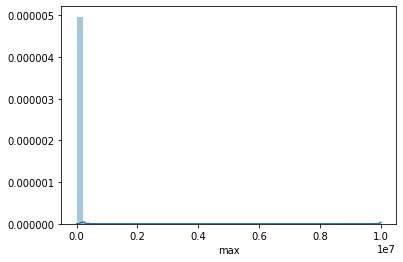

In [28]:
filtered_max = dataset_B[dataset_B['ID'] in]

In [ ]:
merged = dataset_A.merge(dataset_B, how='inner', on=['ID', 'COMMITMENT_PREFIX'])

# Tiny change from Charmaine - test git on .ipynb

In [45]:
# notes:

# In addition to the dates that are null (see above) because some data exists in court commitment
# that doesnt exist in sentence computation (and vice versa) we also have start and end
# dates that are 0001-01-01 - based on looking up some offenders with these dates, these
# are often just missing so 0001-01-01 is a placeholder for missing date

# There are about 10k observations with end_date = 0001-01-01. These don't seem random -
# 9k of these are for the commitment prefix BA, and on spot checking many of them look like
# the sentences were categorized as "FAIR FELONS" - related to the fair sentencing act that
# affects sentences from 1982 to October 1994 (before NC enacted structured sentencing which
# abolished parole). It also seems like many of those sentences are missing an "actual release
# date" from prison but have a release date from parole
# 
# Where available, the end date will be replaced with the projected release date. on spot
# checking, this seems to be a reasonable proxy for when inmate was last moved
# There are 397 observations missing both end date and projected end date - dropping these
#
# About 12k observations have start date = 0001-01-01. On spot checking, some of these
# appear to be entirely missing from sentence component and from the offender's online
# profile - as if the sentences were removed ex-post. Since there is no way to get a start
# date for these, they will be dropped. Approx 1% of the data

# Also note - to get "Active" sentences, we should probably not trust the Inmate Commitment
# status flag in court commitment. This often appears active even for sentences that
# online show "service status" = "Expired"

# instead, we should merge on information from INmate Profile. This has "inmate record status"
# and current commitment prefix - merging on ID and commitment prefix, we can figure out if the
# offenders latest sentence is something they are still actively serving

# Figuring out which sentences never ended (e.g. life imprsonment) but are inactive
# might be a bit harder... 


# Accounting for observations
# 158261 + 692709
# 888120 - 850970
# ~ 37k missing a recidivism flag. approx 32k of those should be currently active sentences
# of remaining ~4k, most have type of last movement  = DEATH

# need to sanity check other edge cases where nextprefix = 0 should get NA rather than 0

# Decision rule for recidivism flag:
# 1. if nextPrefix is not 0
#    a. if nextStart - endDate is less than XXX (make this a param) then recidivism = 1 else 0
# 2. if nextPrefix is 0
#    a. If active -> no recidivism flag
#    b. if inactive:
#        - ever released?
#            - if yes - recidivism = 0
#            - if no - no recidivism flag
#   a. if end date is NOT 9999-01-02 (stand in for LIFE) then recidivism = 0
#   b. if end date is 9999-01-02 see active flag, 
#       - if active, then no recidivism flag
#        - if not active and type of last movement = death, then no recidivism flag (this will get dropped)
#        - if not active and type of last movement = other things (e.g. court ordered release)
# then recidivism = 0


In [134]:
data.shape

(903181, 20)

In [135]:
data.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT
0,0000004,AA,1983-07-12,None,EXPIRED,1984-07-11,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,NaN
1,0000006,AA,1973-01-30,None,EXPIRED,1973-03-28,0001-01-01,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN
2,0000006,AB,1973-04-11,None,EXPIRED,1975-08-18,1974-08-10,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN
3,0000008,AA,1990-04-09,None,EXPIRED,1990-05-17,1990-10-09,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN
4,0000008,AB,1993-08-30,None,EXPIRED,1994-01-26,1994-02-18,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN


In [136]:
# Clean up dates in dataset A:
# 1. replace end date with projected end date where END_DATE = 0001-01-01
# 2. drop observations still missing end_date
# 3. drop observations missing EARLIEST_SENTENCE_EFFECTIVE_DT

# https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/
data['END_DATE'].mask(data['END_DATE'] == '0001-01-01', data['PROJ_END_DATE'], inplace=True)

In [137]:
# sanity check
data_weird_enddate = data[(data['END_DATE']=='0001-01-01') ]
data_weird_enddate.shape

(397, 20)

In [138]:
# 2 and 3 and dropping those where the sentence is either only in court commitment or only in sentence comp
data = data[data['END_DATE']!='0001-01-01']
data = data[data['EARLIEST_SENTENCE_EFFECTIVE_DT']!='0001-01-01']
data = data[data['END_DATE'].notna()]
data = data[data['EARLIEST_SENTENCE_EFFECTIVE_DT'].notna()]
data.shape

(888120, 20)

In [139]:
conn = sqlite3.connect(':memory:')
data.to_sql('data', conn, index=False)

In [140]:
start = datetime.datetime.now()
# https://stackoverflow.com/questions/37360901/sql-self-join-compare-current-record-with-the-record-of-the-previous-date
query_datasetA = '''
                        SELECT *, 
                        LEAD(COMMITMENT_PREFIX,1,0) OVER (
                                                    PARTITION BY ID
                                                    ORDER BY COMMITMENT_PREFIX
                                                    ) NextPrefix,
                        LEAD(EARLIEST_SENTENCE_EFFECTIVE_DT,1,0) OVER (
                                                    PARTITION BY ID
                                                    ORDER BY COMMITMENT_PREFIX
                                                    ) NextStart,
                        LEAD(MOST_SERIOUS_OFFENSE_CODE,1,0) OVER (
                                                    PARTITION BY ID
                                                    ORDER BY COMMITMENT_PREFIX
                                                    ) NextOffense                                                    
                                                    
                        FROM data ;

                        '''


dataset_flag = qd.query_db_notebook(conn,query_datasetA)
conn.close
stop = datetime.datetime.now()
print("Time Elapsed:", stop - start) 

Time Elapsed: 0:01:04.739059


In [141]:
#dataset_flag.groupby('TYPE_OF_LAST_INMATE_MOVEMENT').count()

In [142]:
import numpy as np

In [143]:


def fix_dates(data,date_var):
    data['new_col'] = data[date_var].astype(str).str[0:4].astype(int)
    data.loc[data['new_col']>2261, date_var] = '2261-01-02'
    data[date_var] = data[date_var].replace(0,np.nan)
    data.loc[data[date_var]=="0", date_var] = None
    data[date_var] = pd.to_datetime(data[date_var],format='%Y-%m-%d',errors='coerce')
    #df[date_var] = pd.to_datetime(df[date_var].str.split(n=1).str[0],format='%Y-%m-%d')
    return data


def get_recidivism_label(data,num_years=1):
    data['Time_Diff'] = pd.DatetimeIndex(data['NextStart']).year - pd.DatetimeIndex(data['END_DATE']).year
    data['Recidivate'] = np.nan
    # if NextPrefix != 0:
    data.loc[(data['NextPrefix']!=0) & (data['Time_Diff']<= num_years), 'Recidivate'] = 1
    data.loc[(data['NextPrefix']!=0) & (data['Time_Diff']> num_years), 'Recidivate'] = 0
    
    # if nextprefix = 0, inmate is inactive, and they did not die in prison 
    # (e.g. serving life sentence or  other wise) then 
    # recidivism = 0
    data.loc[(data['NextPrefix']==0) & (data['INMATE_ADMIN_STATUS_CODE']=='INACTIVE') & (data['TYPE_OF_LAST_INMATE_MOVEMENT']!='DEATH'), 'Recidivate'] = 0
    
    # if nextprefix = 0, inmate status code is not active or inactive(could be missing) and 
    # end date is not 2261-01-02 (life sentence), they were likely released from prison
    # recidivism = 0
    data.loc[(data['NextPrefix']==0) & (data['INMATE_ADMIN_STATUS_CODE']!='ACTIVE') & (data['INMATE_ADMIN_STATUS_CODE']!='INACTIVE') & (data['END_DATE']!='2261-01-02'), 'Recidivate'] = 0
    
    
    return data



In [144]:
dataset_flag.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense
0,0000004,AA,1983-07-12,None,EXPIRED,1984-07-11,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,NaN,0,0,0
1,0000006,AA,1973-01-30,None,EXPIRED,1973-03-28,0001-01-01,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1973-04-11,None
2,0000006,AB,1973-04-11,None,EXPIRED,1975-08-18,1974-08-10,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,0,0,0
3,0000008,AA,1990-04-09,None,EXPIRED,1990-05-17,1990-10-09,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1993-08-30,None
4,0000008,AB,1993-08-30,None,EXPIRED,1994-01-26,1994-02-18,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,BA,1995-01-02,None


In [145]:
#dataset_flag[dataset_flag['NextStart']=="0"].count()

In [146]:
dataset_flag = fix_dates(dataset_flag,'EARLIEST_SENTENCE_EFFECTIVE_DT')


In [147]:
dataset_flag = fix_dates(dataset_flag,'END_DATE')
dataset_flag = fix_dates(dataset_flag,'NextStart')

In [148]:
dataset_flag.dtypes

ID                                        object
COMMITMENT_PREFIX                         object
EARLIEST_SENTENCE_EFFECTIVE_DT    datetime64[ns]
MOST_SERIOUS_OFFENSE_CODE                 object
INMATE_COMPUTATION_STATUS_FLAG            object
END_DATE                          datetime64[ns]
PROJ_END_DATE                             object
INMATE_RECORD_STATUS_CODE                 object
INMATE_ADMIN_STATUS_CODE                  object
DATE_OF_LAST_INMATE_MOVEMENT              object
TYPE_OF_LAST_INMATE_MOVEMENT              object
CURRENT_COMMITMENT_PREFIX                 object
CONTROL_STATUS                            object
GENDER                                    object
RACE                                      object
BIRTH_DATE                                object
STATE_BORN                                object
ETHNICITY                                 object
CITIZENSHIP                               object
DISCIPLINARY_INFRACTION_COUNT            float64
NextPrefix          

In [149]:
dataset_flag = get_recidivism_label(dataset_flag)

In [150]:
dataset_flag.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate
0,0000004,AA,1983-07-12,None,EXPIRED,1984-07-11,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,NaN,0,NaT,0,0,NaN,0.0
1,0000006,AA,1973-01-30,None,EXPIRED,1973-03-28,0001-01-01,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1973-04-11,None,1973,0.0,1.0
2,0000006,AB,1973-04-11,None,EXPIRED,1975-08-18,1974-08-10,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,0,NaT,0,0,NaN,0.0
3,0000008,AA,1990-04-09,None,EXPIRED,1990-05-17,1990-10-09,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1993-08-30,None,1993,3.0,0.0
4,0000008,AB,1993-08-30,None,EXPIRED,1994-01-26,1994-02-18,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,None,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,BA,1995-01-02,None,1995,1.0,1.0


In [151]:
dataset_flag.groupby('Recidivate').count()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff
Recidivate,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,692709,692709,692709,452527,692709,692709,692709,688110,688110,688110,682473,519274,688110,692709,692708,692709,665212,692031,692046,408973,692709,261928,636906,692709,261928
1.0,158261,158261,158261,89784,158261,158261,158261,156644,156644,156644,153285,129531,156644,158261,158260,158261,156132,158247,158255,131796,158261,158261,102429,158261,158261


In [152]:
# Bring in coded offenses
dataset_with_offenses = dataset_flag.merge(coded_offenses, how='left', left_on='MOST_SERIOUS_OFFENSE_CODE', right_on='Primary offense code')


In [153]:
dataset_with_offenses.sample()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate,Primary offense code,Description (if needed),Decided Category,Needed a check?,More lenient,More harsh
469133,0423886,BA,2003-08-25,POSSESS SCHEDULE II,EXPIRED,2004-01-29,2004-01-29,INACTIVE,INACTIVE,2004-01-29,EXPIRATION,BA,REGULAR POPULATION RPOP,FEMALE,BLACK,1963-09-23,NORTH CAROLINA,AFRICAN,BORN IN U.S.,NaN,0,NaT,0,0,NaN,0.0,POSSESS SCHEDULE II,Has a high potential for abuse. Has accepted ...,2.0,NO,2.0,2.0


In [154]:
# Accounting for observations:
    # how many observations are missing a most serious offense code? this should be approximately 33% of the data
    # of the remaining 66%, how many are missing "primary offense code" which comes from the offenses we coded up?
    # of offenses that have most serious offense code, we are missing primary offense coded for ~4% of the data
    # this makes sense, since we intentionally coded up offenses that accounted for 95% of our data
#dataset_with_offenses['MOST_SERIOUS_OFFENSE_CODE'].isnull().sum()
dataset_with_offenses[dataset_with_offenses['MOST_SERIOUS_OFFENSE_CODE'].notnull()]['Primary offense code'].isnull().sum()


35340

In [155]:
35340/dataset_with_offenses.shape[0]

0.03979192001080935

In [156]:
dataset_with_offenses.groupby('Decided Category').count()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate,Primary offense code,Description (if needed),Needed a check?,More lenient,More harsh
Decided Category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,119470,119470,119470,119470,119470,119470,119470,118730,118730,118730,116888,118516,118730,119470,119470,119470,117632,119369,119367,78477,119470,58417,119457,119470,58417,117330,119470,119470,119470,119470,119470
2.0,144024,144024,144024,144024,144024,144024,144024,143151,143151,143151,141158,142919,143151,144024,144024,144024,141553,143891,143893,97075,144024,77104,144007,144024,77104,142126,144024,144024,144024,144024,144024
3.0,202077,202077,202077,202077,202077,202077,202077,201155,201155,201155,196412,200950,201155,202077,202077,202077,192885,201694,201706,150261,202077,78461,202072,202077,78461,187798,202077,202077,202077,202077,202077
4.0,57114,57114,57114,57114,57114,57114,57114,56696,56696,56696,55781,56634,56696,57114,57114,57114,54996,57081,57082,39969,57114,25408,57108,57114,25408,55196,57114,57114,57114,57114,57114
5.0,19751,19751,19751,19751,19751,19751,19751,19695,19695,19695,18109,19673,19695,19751,19751,19751,18648,19746,19747,17807,19751,2591,19748,19751,2591,11155,19751,19751,19751,19751,19751


In [157]:
119470 + 144024 + 202077 + 57114 + 19751

542436

In [158]:
202077/542436

0.3725361148596332

In [159]:
dataset_with_offenses.shape

(888120, 32)

In [160]:
# drop observations with no recidivism prediction that are not active
dataset_with_offenses = dataset_with_offenses[(dataset_with_offenses['INMATE_ADMIN_STATUS_CODE']!='ACTIVE') & (dataset_with_offenses['Recidivate'].notnull())]


In [161]:
dataset_with_offenses.shape

(799062, 32)

In [162]:
# demographic data is not missing in inmate profile, but its missing systematically for ~6000 observations
# in final dataset - which 6k observations are missing in inmate profile?

# based on spot checking many of the 6k obs missing from inmate profile, it appears that NC offender search says
# their incarceration record is currently unavailable - not sure for what reason

# so it makes sense to try and get a lot of these variables from other datasets where possible (e.g. demographics
# from offender profile, disciplinary infractions from the displinary infractions dataset)
inmt_profile.isnull().sum()

ID                                   0
INMATE_RECORD_STATUS_CODE            0
INMATE_ADMIN_STATUS_CODE             0
DATE_OF_LAST_INMATE_MOVEMENT         0
TYPE_OF_LAST_INMATE_MOVEMENT      5774
CURRENT_COMMITMENT_PREFIX       143128
CONTROL_STATUS                       0
dtype: int64

In [163]:
# by bringing in data from other sources, there are a lot fewer missings
# still - need to decide how to deal with features that are missing
dataset_with_offenses.isnull().sum()

ID                                     0
COMMITMENT_PREFIX                      0
EARLIEST_SENTENCE_EFFECTIVE_DT         0
MOST_SERIOUS_OFFENSE_CODE         300245
INMATE_COMPUTATION_STATUS_FLAG         0
END_DATE                               0
PROJ_END_DATE                          0
INMATE_RECORD_STATUS_CODE           6216
INMATE_ADMIN_STATUS_CODE            6216
DATE_OF_LAST_INMATE_MOVEMENT        6216
TYPE_OF_LAST_INMATE_MOVEMENT        7543
CURRENT_COMMITMENT_PREFIX         202060
CONTROL_STATUS                      6216
GENDER                                 0
RACE                                   2
BIRTH_DATE                             0
STATE_BORN                         29307
ETHNICITY                            692
CITIZENSHIP                          669
DISCIPLINARY_INFRACTION_COUNT     308183
NextPrefix                             0
NextStart                         430781
NextOffense                       107533
new_col                                0
Time_Diff       

In [83]:
dataset_with_offenses[dataset_with_offenses['INMATE_RECORD_STATUS_CODE'].isnull()].sample(100)

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,GENDER,RACE,BIRTH_DATE,ETHNICITY,CONTROL_STATUS,SPECIAL_CHARS,TOTAL_DISCIPLINE_INFRACTIONS,LATEST_DISCIPLINE_INFRACTION,LAST_DISCIPLINE_INFRACTION_DT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate,Primary offense code,Description (if needed),Decided Category,Needed a check?,More lenient,More harsh
181916,0163821,BA,1998-07-06,DRUG PARA - USE/POSSESS,EXPIRED,1998-10-30,1998-10-30,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,NaT,0,0,NaN,0.0,DRUG PARA - USE/POSSESS,"Use or possession of drug ""paraphernalia"" - an...",1.0,NO,1.0,1.0
673939,0732208,BA,2008-08-05,COMMUNICATING THREATS,EXPIRED,2008-10-08,2008-10-08,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BB,2010-06-07,FELONY B&E,2010,2.0,0.0,COMMUNICATING THREATS,0,2.0,YES,1.0,3.0
83496,0074408,BA,1996-08-21,POSSESSION OF FIREARM BY FELON,EXPIRED,1996-11-15,1996-11-19,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BB,2006-07-10,RIOT & CIVIL DISORDERS,2006,10.0,0.0,POSSESSION OF FIREARM BY FELON,0,3.0,YES,2.0,4.0
736755,0870014,BA,2005-05-26,AWDWISI,EXPIRED,2005-10-02,2005-10-02,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BB,2006-06-30,AWDWISI,2006,1.0,1.0,AWDWISI,Assault with a deadly weapon - inflicting seri...,4.0,NO,4.0,4.0
136071,0122086,AE,1987-02-26,None,EXPIRED,1987-08-26,1987-08-26,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,NaT,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
822741,1187240,BA,2012-01-17,INDECENT LIBERTY W/CHILD,EXPIRED,2012-11-15,2012-11-15,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BB,2016-08-30,POSSESSION OF FIREARM BY FELON,2016,4.0,0.0,INDECENT LIBERTY W/CHILD,0,4.0,NO,4.0,4.0
353911,0318344,AC,1989-03-20,None,EXPIRED,1990-01-10,1990-01-10,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,NaT,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
734475,0862885,BA,2009-05-15,ASSAULT BY STRANGULATION,EXPIRED,2010-03-19,2010-03-19,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BB,2011-01-18,DWI LEVEL 1,2011,1.0,1.0,ASSAULT BY STRANGULATION,0,4.0,NO,4.0,4.0
226004,0202876,BA,1995-05-30,UNAUTH USE MOTOR CONVEYANCE,EXPIRED,1996-11-23,1996-11-23,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,NaT,0,0,NaN,0.0,UNAUTH USE MOTOR CONVEYANCE,0,1.0,NO,1.0,1.0
653641,0692991,BD,2013-02-12,FAIL VERFY ADDR SEXOFFENDR,EXPIRED,2013-12-07,2013-12-06,None,None,None,None,None,None,None,None,None,None,None,None,None,None,BE,2015-01-22,FAIL/NOTFY CHG ADDR SEXOFF,2015,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [395]:
#dataset_flag.fillna(-1).groupby('INMATE_ADMIN_STATUS_CODE').count()
dataset_flag[(dataset_flag['NextPrefix']==0) & (dataset_flag['INMATE_ADMIN_STATUS_CODE']=='ACTIVE')].count()

ID                                32801
COMMITMENT_PREFIX                 32801
EARLIEST_SENTENCE_EFFECTIVE_DT    32801
MOST_SERIOUS_OFFENSE_CODE         32796
INMATE_COMPUTATION_STATUS_FLAG    32801
END_DATE                          32801
PROJ_END_DATE                     32801
INMATE_RECORD_STATUS_CODE         32801
INMATE_ADMIN_STATUS_CODE          32801
DATE_OF_LAST_INMATE_MOVEMENT      32801
TYPE_OF_LAST_INMATE_MOVEMENT      27587
CURRENT_COMMITMENT_PREFIX         32729
NextPrefix                        32801
NextStart                             0
NextOffense                       32801
new_col                           32801
Time_Diff                             0
Recidivate                            0
dtype: int64

In [36]:
#dataset_flag['NextStart'] = dataset_flag['NextStart'].replace(0,np.nan)


In [393]:
#dataset_flag[dataset_flag['INMATE_ADMIN_STATUS_CODE']=="ACTIVE"].head(100)

In [46]:
#dataset_missing_flag = dataset_flag[(dataset_flag['Recidivate'].isnull()) & (dataset_flag['INMATE_ADMIN_STATUS_CODE']!='ACTIVE')]
             
             

In [47]:
#dataset_missing_flag.groupby('TYPE_OF_LAST_INMATE_MOVEMENT').count()

In [221]:
#data_weird_enddate = data[(data['END_DATE']=='0001-01-01') & (data['PROJ_END_DATE']=='0001-01-01') ]
#data_weird_enddate.shape

In [224]:
#court_small[(court_small['INMATE_COMPUTATION_STATUS_FLAG']=='ACTIVE') & (court_small['PROJ_END_DATE']=='9999-01-02')].head()



In [208]:
#sentence_component_example[(sentence_component_example['INMATE_RECORD_STATUS_CODE']=="ACTIVE") & (sentence_component_example['CURRENT_COMMITMENT_PREFIX'].isnull())].head()
#mismatch = sentence_component_example[sentence_component_example['INMATE_RECORD_STATUS_CODE']!=sentence_component_example['INMATE_ADMIN_STATUS_CODE']]
#data = court_small.merge(sentence_compute_small, on=['ID','COMMITMENT_PREFIX'], how='outer')

In [220]:
#data.shape

In [219]:
#data_merge.groupby('INMATE_ADMIN_STATUS_CODE').count()

In [217]:
#sentence_component_example.groupby('INMATE_ADMIN_STATUS_CODE').count()

In [216]:
#mismatch.groupby('TYPE_OF_LAST_INMATE_MOVEMENT').count()

In [213]:
#325044 - 279693

In [214]:
# query_court_commitment_example = '''
#                                     SELECT * FROM OFNT3BB1 WHERE OFFENDER_NC_DOC_ID_NUMBER = '0000544'
#                                     '''

In [215]:
# conn = create_connection(config.database_name)
# court_commitment_example = qd.query_db_notebook(conn,query_court_commitment_example)
# conn.close

In [212]:
#sentence_component_example

In [211]:
#court_small.head(50)